## note:
1. home all;
2. G1 X0 Y0;
3. G29 S1; Load height map from file
4. lower the z axis unitl the syringe tip touches the build plate
5. G92 Z0; set current z height as 0

### for mesh bed compensation, refer to:
https://duet3d.dozuki.com/Wiki/Using_mesh_bed_compensation

In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
from sys import platform

# helper scripts defined in the "./musclePrinting" folder
from musclePrinting.point_in_polygon import wn_PnPoly
from musclePrinting.pathplanner import *
from musclePrinting.muscle_printing import *

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")

# As defined in muscle_printing:
# SKIN = 2
# MUSCLE  = 1

In [2]:
TOOL = { # ratio between extruders
    CONDUCTIVE:[0, 0.5, 0, 0.5],
    MUSCLE:[0.5, 0, 0,  0.5],
    SKIN:[0, 0.5, 0.5,  0]
}
D = 22.63
# d = 2.75 # test

d = 1.75 # gauge14
# d = 1.15  # gauge16
# d = 0.99 # guage18

# works: 'feedrate_move':600
# 'feedrate_quickmove':7000,
# 'dump_location':[160, 100, 75],
gcode_para = { # G code parameters
    'D':D,
    'd':d,
    'applied_percentage':1,
    'TOOL':TOOL,
    'dump_location':[50, 50, 30],
    'feedrate_move':600,
    'feedrate_quickmove':6000,
    'feedrate_extrude':(d**2) / (330**2),
    'total_volume_change':3820.0, # [mm^3]
    'max_reuse_volume':1450,
    }
#################################################################################################

# # for one material only!
# copied from the Soft_muscle_v2
# initial_dump_amount = 6.2

# for two material
# initial_dump_amount = 10
initial_dump_amount = 10.5

initial_gcode = ''.join([
#     'G29 S1; load probe setting\n',
    'G92 Z0;set current z as z=0\n',
    'F{0}\n'.format(gcode_para['feedrate_quickmove']),
    'G0 X{0} Y{1} Z{2}\n'.format(gcode_para['dump_location'][0],
                                 gcode_para['dump_location'][1],
                                 gcode_para['dump_location'][2]),
    multipledumping(amount = initial_dump_amount,extruder=TOOL[SKIN],feedrate_extrude = gcode_para['feedrate_extrude'],
                    delta = 0.10,wait = 400,lastWait = 6000),
    'G0 F{0:.7f}\n'.format(gcode_para['feedrate_quickmove'])])
print(initial_gcode)

G92 Z0;set current z as z=0
F6000
G0 X50 Y50 Z30
G1 F0.000028
G1 E0.000000:0.050000:0.050000:0.000000 F0.000028
G4 P400
G1 E0.000000:0.050000:0.050000:0.000000 F0.000028
G4 P400
G1 E0.000000:0.050000:0.050000:0.000000 F0.000028
G4 P400
G1 E0.000000:0.050000:0.050000:0.000000 F0.000028
G4 P400
G1 E0.000000:0.050000:0.050000:0.000000 F0.000028
G4 P400
G1 E0.000000:0.050000:0.050000:0.000000 F0.000028
G4 P400
G1 E0.000000:0.050000:0.050000:0.000000 F0.000028
G4 P400
G1 E0.000000:0.050000:0.050000:0.000000 F0.000028
G4 P400
G1 E0.000000:0.050000:0.050000:0.000000 F0.000028
G4 P400
G1 E0.000000:0.050000:0.050000:0.000000 F0.000028
G4 P400
G1 E0.000000:0.050000:0.050000:0.000000 F0.000028
G4 P400
G1 E0.000000:0.050000:0.050000:0.000000 F0.000028
G4 P400
G1 E0.000000:0.050000:0.050000:0.000000 F0.000028
G4 P400
G1 E0.000000:0.050000:0.050000:0.000000 F0.000028
G4 P400
G1 E0.000000:0.050000:0.050000:0.000000 F0.000028
G4 P400
G1 E0.000000:0.050000:0.050000:0.000000 F0.000028
G4 P400
G1 E0.0000

In [3]:
# loop to add z dimension to path_list
def add_Z(path_list,z,tool,z_g0 = None):
    """ return a list [tool,path_with_z0, path_with_z1,...]
    # z_g0 is the hight the syringe tip will go to when it start or finish a path
    @boxiXia;@jacobjoseph
    """
    if type(path_list)!=list:
        path_list = [path_list]
        
    if (type(z) is not list) and (type(z) is not np.ndarray):
        z_list = np.array([z])
    else:
        z_list = np.array(z)
        
    new_path_list = [tool]
    for z_k in z_list:
        for path in path_list:
            path_with_z =np.hstack([path,np.ones((path.shape[0],1))*z_k])

            if z_g0 is not None:
                firstPoint = [path_with_z[0,0],path_with_z[0,1],z_g0]
                lastPoint = [path_with_z[-1,0],path_with_z[-1,1],z_g0]
                path_with_z = np.vstack([firstPoint,path_with_z,lastPoint])
            new_path_list.append(path_with_z)       
            
    return(new_path_list)

def height_vector(num_layers,layer_height,z_start,a=0.85,b=0.25):
    """
    height_vector return the z height for printing each layer.
    num_layers is the total number of layer
    layer_height is the ideal layer height, usually it is the printer tip diameter
    z_start is the starting Z height
    b controls the speed of layer height transition
    a is the final layer height
    @jacobjoseph;@boxiXia
    """
    k = np.arange(0,num_layers)
    z_k = z_start + layer_height*(k*a+(1-a)*np.exp(-b)*(1-np.exp(-b*k))/(1-np.exp(-b)))
    cylinder_height = z_k[-1]-z_k[0]
    print("total_height>={0:.3f}".format(cylinder_height))
    return(z_k)

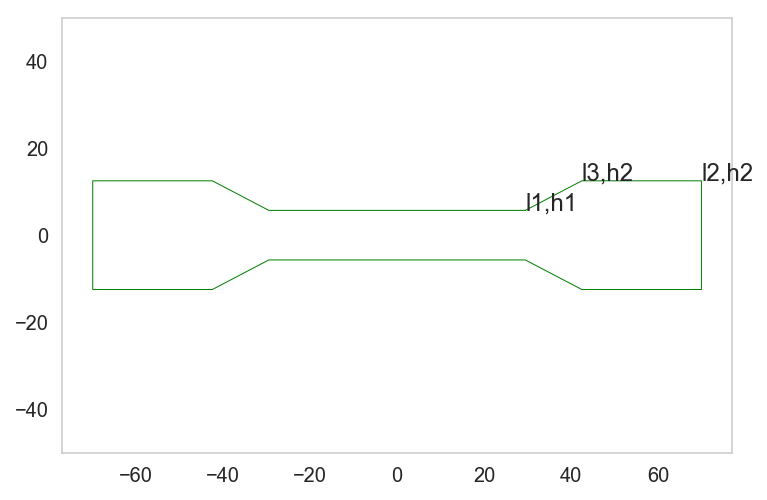

In [4]:
def DogBone(l1,l2,l3,h1,h2,x,y,plotting = False,shift = 0):
    ## example:
    # dog_bone = DogBone(l1= 20,l2=50,l3= 30,h1=10,h2=20,x= 0,y= 0,plotting=True)
    #
    dog_bone = np.array([[l1/2+x,h1/2+y],
                         [l3/2+x,h2/2+y],
                         [l2/2+x,h2/2+y],
                         [l2/2+x,-h2/2+y],
                         [l3/2+x,-h2/2+y],
                         [l1/2+x,-h1/2+y],
                         [-l1/2+x,-h1/2+y],
                         [-l3/2+x,-h2/2+y],
                         [-l2/2+x,-h2/2+y],
                         [-l2/2+x,h2/2+y],
                         [-l3/2+x,h2/2+y],
                         [-l1/2+x,h1/2+y]])
    if shift!=0:
        dog_bone = np.roll(dog_bone,shift,axis = 0 )
    dog_bone =np.vstack((dog_bone,dog_bone[0]))
    if plotting:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(dog_bone[:,0],dog_bone[:,1],color ='g',linewidth = 0.5)
        # for k in range(len(dog_bone)-1):
        #     ax.text(dog_bone[k,0],dog_bone[k,1], k, 
        #         fontsize=12,horizontalalignment='center',verticalalignment = 'center')
        ax.text(dog_bone[0,0],dog_bone[0,1], 'l1,h1', fontsize=12)
        ax.text(dog_bone[1,0],dog_bone[1,1], 'l3,h2', fontsize=12)
        ax.text(dog_bone[2,0],dog_bone[2,1], 'l2,h2', fontsize=12)
        plt.axis('equal');plt.grid();plt.show();
    return dog_bone

def StandardDogBone(x,y,Die,plotting=False,shift = 0):
    if Die =='A': 
        # For ASTM D412-16 Die A
        l1=59
#         l3 = 74 # for 45 degree angle from inner to outer rectangle
        l3 = 84.98 # for 30 degree angle from inner to outer rectangle
        l2=140
        h1=11.4
        h2=25
    elif Die =='C':
        # For ASTM D412-16 Die C
        l1=59
        #  l3 = 74 # for 45 degree angle from inner to outer rectangle
        l3 = 84.98 # for 30 degree angle from inner to outer rectangle
        l2=115
        h1=5.4
        h2=25
    # height of ASTM D412-16 Die A is 3 mm
    return DogBone(l1,l2,l3,h1,h2,x,y,plotting,shift)
dog_bone = StandardDogBone(0,0,'A',plotting=True)

In [5]:
def plotPath(lines):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(lines[:,0],lines[:,1],color ='g',linewidth = 0.5)
    for k in range(len(lines)-1):
        ax.text(lines[k,0],lines[k,1], k, 
            fontsize=12,horizontalalignment='center',verticalalignment = 'center')
    plt.axis('equal');plt.grid();plt.show();

In [6]:
def polygon_path(lines,d, angle = 0,plotting = False, **kwargs):
    r = d/2
    if angle!=0:
        lines = np.dot(lines,rotation_2d(angle))
    # if (x_max-x_min)%d>0.5, then offset smaller distance    
    if (lines[:,0].max()-lines[:,0].min())%d>0.5:
        offset = 0.75*d
    else:
        offset = 0.95*d
    lines_offset = offset_lines(lines,offset,left = False)
    if wn_PnPoly(lines_offset[0], lines)==0:
        lines_offset = offset_lines(lines,offset,left = True)


    num_lines = len(lines)-1
    #####################################################
    # sample from x and get intercetion points
    x_max,y_max = lines_offset.max(axis=0)
    x_min,y_min = lines_offset.min(axis=0)
    # move x_min a little bit to the right so that
    # x_min and x_max are symmetric
    x_min = x_min+(x_max-x_min)%d/2*d
    x = np.arange(x_min,x_max,d) # x value of the sampling points
    num_x = len(x)
    # each row of the y_list is a set, to eliminate duplicates
    y_list = [set() for k in range(num_x)]

    for k in range(num_lines): 
        if lines_offset[k,0] != lines_offset[k+1,0]: # not vertical line
            if lines_offset[k,0] > lines_offset[k+1,0]:
                x_left,x_right = lines_offset[k+1,0],lines_offset[k,0]
            elif lines_offset[k,0] < lines_offset[k+1,0]:
                x_left,x_right = lines_offset[k,0],lines_offset[k+1,0]
    #         print(x_left,x_right)
            for i,intercepted in enumerate((x>=x_left)&(x<=x_right)):
                if intercepted:
                    x_intercept = x[i]
                    y_intercept = (x_intercept-lines_offset[k,0])/(lines_offset[k+1,0]-lines_offset[k,0])*(lines_offset[k+1,1]-lines_offset[k,1])+lines_offset[k,1]
    #                 print(x_intercept,y_intercept)
    #                 y_list[i].append(y_intercept)
                    y_list[i].add(y_intercept)

    # remove repeating point, and sort in rising order    
    for k in range(num_x):
        y_list[k]= list(y_list[k])
        y_list[k].sort()

    # # plot
    # fig = plt.figure()
    # ax = fig.add_subplot(111)
    # for k,y in enumerate(y_list):
    #     ax.plot([x[k]]*len(y),y,'*')
    # for k in range(num_lines):
    #     ax.plot(lines[k:k+2,0],lines[k:k+2,1],color ='g')
    #     ax.plot(lines_offset[k:k+2,0],lines_offset[k:k+2,1],color ='b')
    #     ax.text(lines_offset[k,0],lines_offset[k,1], k, fontsize=12)
    # plt.axis('equal');plt.grid();plt.show()
    # # print(np.array(y_list))

    #######################
    # if the sampling point_x coinside with the endpoint of lines_offset
    # need to figure out which path lies inside the polygon
    line_x_set=set(lines_offset[:,0])
    for k in range(num_x):
        if x[k] in line_x_set:
            y_list_k = []
            for i in range(len(y_list[k])-1):
                y_1 = y_list[k][i]
                y_2 = y_list[k][i+1]
                y_m = (y_1+y_2)/2 # middle point
                # if point (x[k],y_m) does not lie out side
                # of the polygon defined in lines_offset
                if wn_PnPoly([x[k],y_m], lines_offset)!=0:
                    y_list_k.extend([y_1,y_2])
            y_list[k] = y_list_k

    # # plot
    # fig = plt.figure()
    # ax = fig.add_subplot(111)
    # for k,y in enumerate(y_list):
    #     ax.plot([x[k]]*len(y),y,'*')
    # for k in range(num_lines):
    #     ax.plot(lines[k:k+2,0],lines[k:k+2,1],color ='g',linewidth = 0.5)
    #     ax.plot(lines_offset[k:k+2,0],lines_offset[k:k+2,1],color ='b',linewidth = 0.5)
    # plt.axis('equal');plt.grid();plt.show()
    # # print(np.array(y_list))

    # add path to path_list
    num_interction = len(y_list[0])
    path_list = []
    path = []
    done = np.zeros(num_x,dtype=int)
    go_up = True
    k=0
    while np.sum(done)<num_x:
            if len(y_list[k]):
                if len(y_list[k])==num_interction:
                    y_1 = y_list[k][0]
                    y_2 = y_list[k][1]
                    try:
                        if min(abs(path[-1][1]-y_1),abs(path[-1][1]-y_2))>2*d:
                            # print(path[-1][1],y_1,y_2)
                            # if the two points are too far away
                            if path:# if path is not empty
                                path_list.append(path)
                                path = []
    #                                 num_interction = len(y_list[k])

                    except IndexError:
                        pass

                    if y_1>=y_2:
                        path.extend([[x[k],(y_1+y_2)/2]])
    #                     print([[x[k],(y_1+y_2)/2]])
                    elif go_up:
                        path.extend([[x[k],y_1],[x[k],y_2]])
                    else:
                        path.extend([[x[k],y_2],[x[k],y_1]])
                    y_list[k].pop(0)
                    y_list[k].pop(0)
                    k+=1

                    go_up = not go_up
                else:
                    if path:# if path is not empty
                        path_list.append(path)
                        path = []
                    num_interction = len(y_list[k])
            else:
                done[k]=1
                if path:# if path is not empty
                    path_list.append(path)
                    path = []
                num_interction = len(y_list[k])
                k+=1

    #             print(done)
            if k==num_x:
                k=0
                if path:# if path is not empty
                    path_list.append(path)
                    path = []
    path_list = [np.array(path)for path in path_list]

    # # plotting
    # fig = plt.figure()
    # ax = fig.add_subplot(111)
    # for k in range(num_lines):
    #     ax.plot(lines[k:k+2,0],lines[k:k+2,1],color ='g',linewidth = 0.5)
    # for k,path in enumerate(path_list):
    #     ax.plot(path[:,0],path[:,1])
    #     ax.text((path[0,0]+path[-1,0])/2,(path[0,1]+path[-1,1])/2, k, 
    #             fontsize=12,horizontalalignment='center',verticalalignment = 'center')
    # plt.axis('equal');plt.grid();plt.show()

    ###################################################################
    # combine path
    k = 0
    while k<len(path_list):
    #     print(k)
        i = k+1
        while i< len(path_list):
            if norm(path_list[k][-1]-path_list[i][0])<d*2:
                path_list[k]=np.vstack([path_list[k],path_list.pop(i)])
                i=0
                k-=1
            elif norm(path_list[i][-1]-path_list[k][0])<d*2:
                path_list[k]=np.vstack([path_list.pop(i),path_list[k]])
                i=0
                k-=1
            else:
                i+=1
        k+=1
    ######################
    if angle!=0:
        rotation_mat_inverse = rotation_2d(-angle)
        lines = np.dot(lines,rotation_mat_inverse)
        for k,path in enumerate(path_list):
            path_list[k] = np.dot(path,rotation_mat_inverse)       

    if plotting:
        
        linewidth = kwargs['linewidth'] if 'linewidth' in kwargs else 0.5
        indication = kwargs['indication'] if 'indication' in kwargs else True
        figsize = kwargs['figsize'] if 'figsize' in kwargs else (4,4)
        dpi = kwargs['dpi'] if 'dpi' in kwargs else (4,4)
        fig = plt.figure(dpi=dpi,figsize=figsize)
        ax = fig.add_subplot(111)
    #     for k in range(num_lines):
    #         ax.plot(lines[k:k+2,0],lines[k:k+2,1])
        ax.plot(lines[:,0],lines[:,1],color ='k',linewidth = linewidth)
        for k,path in enumerate(path_list):
            if indication ==True:
                ax.plot(path[0,0],path[0,1],'.',linewidth = linewidth)
                ax.text(np.sum(path[:,0])/len(path),np.sum(path[:,1])/len(path), k, 
                    fontsize=12,horizontalalignment='center',verticalalignment = 'center')
            
            ax.plot(path[:,0],path[:,1],linewidth = linewidth)
        plt.axis('equal');plt.grid(True);
        plt.show()   
    return path_list

feedrate_extrude=2.8122130394857668e-05


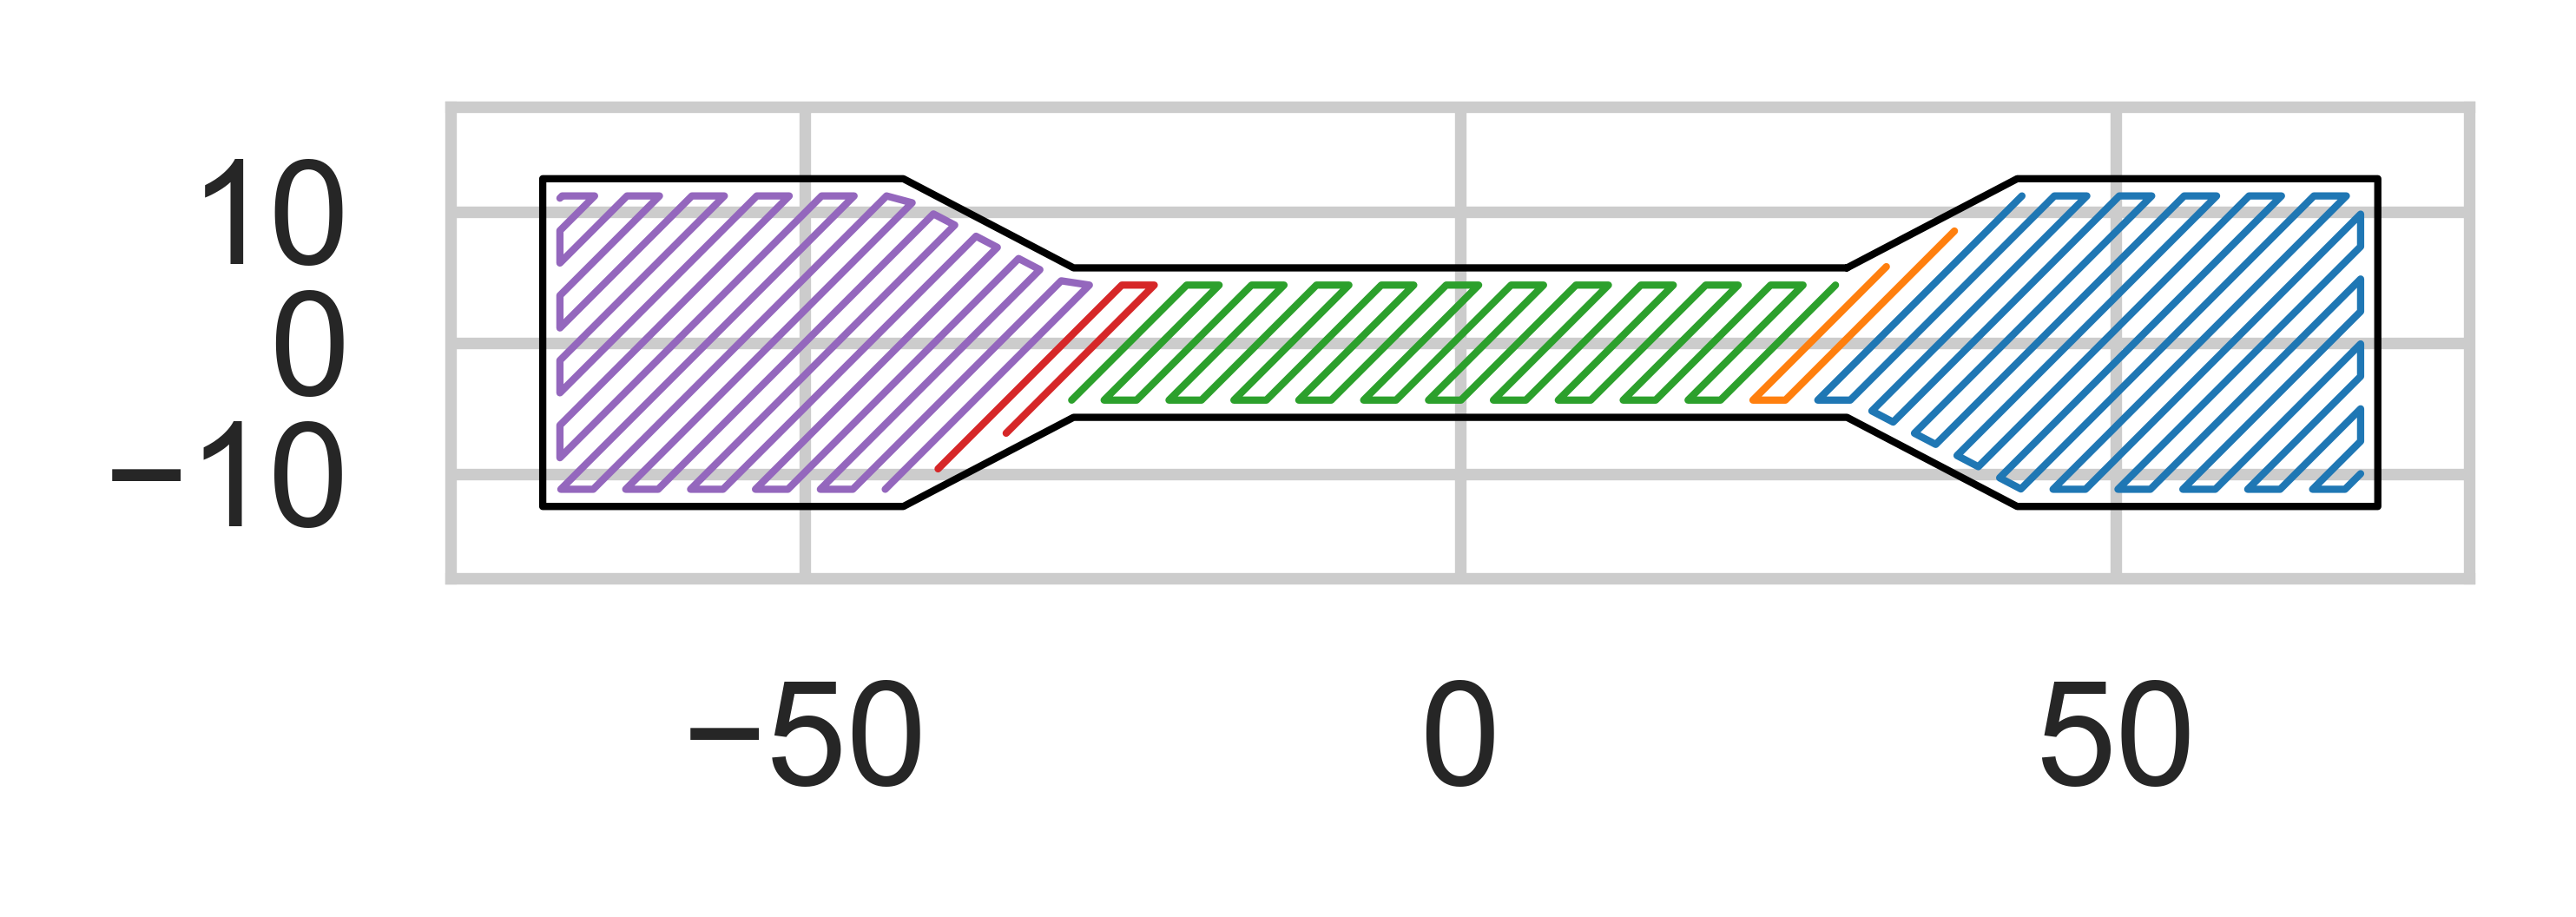

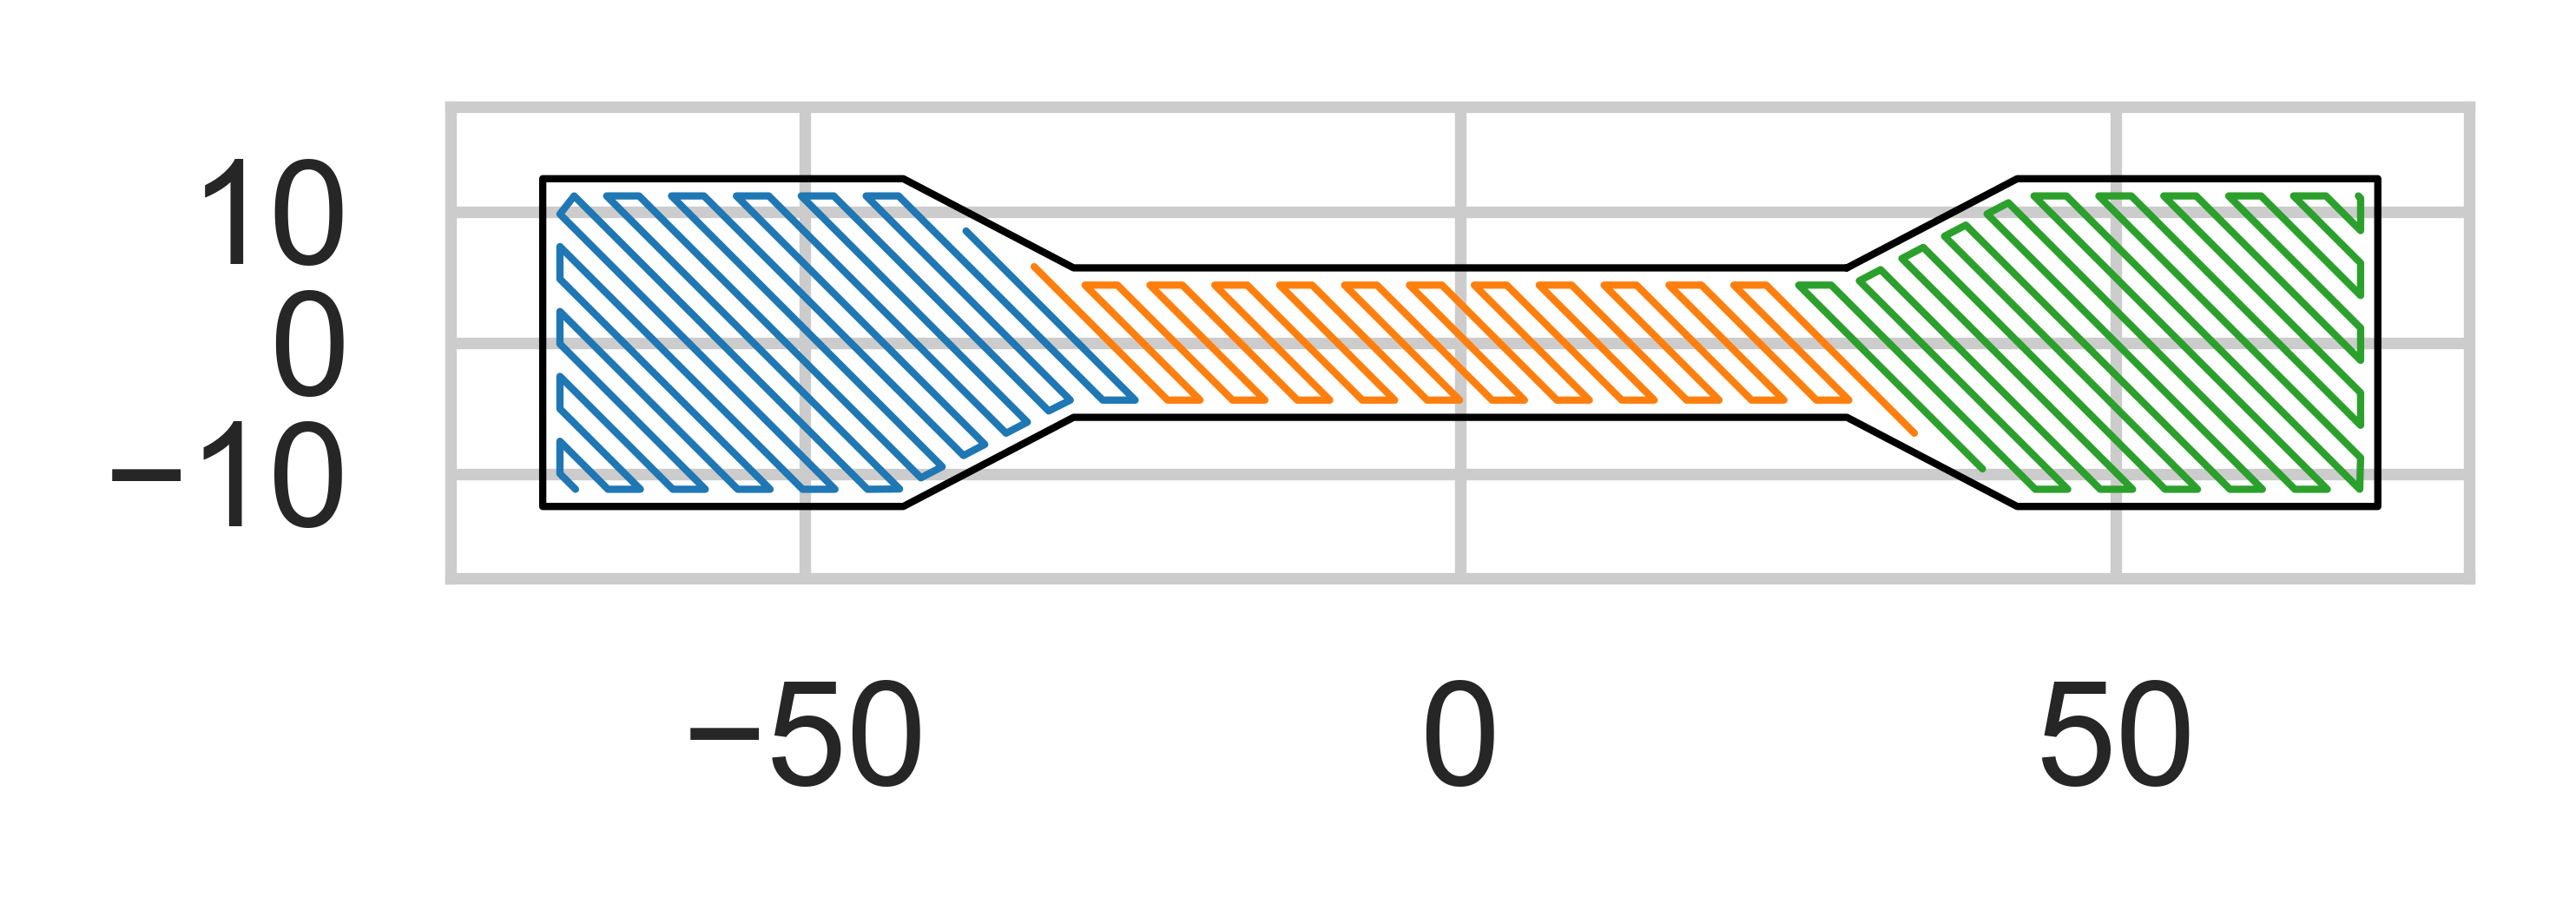

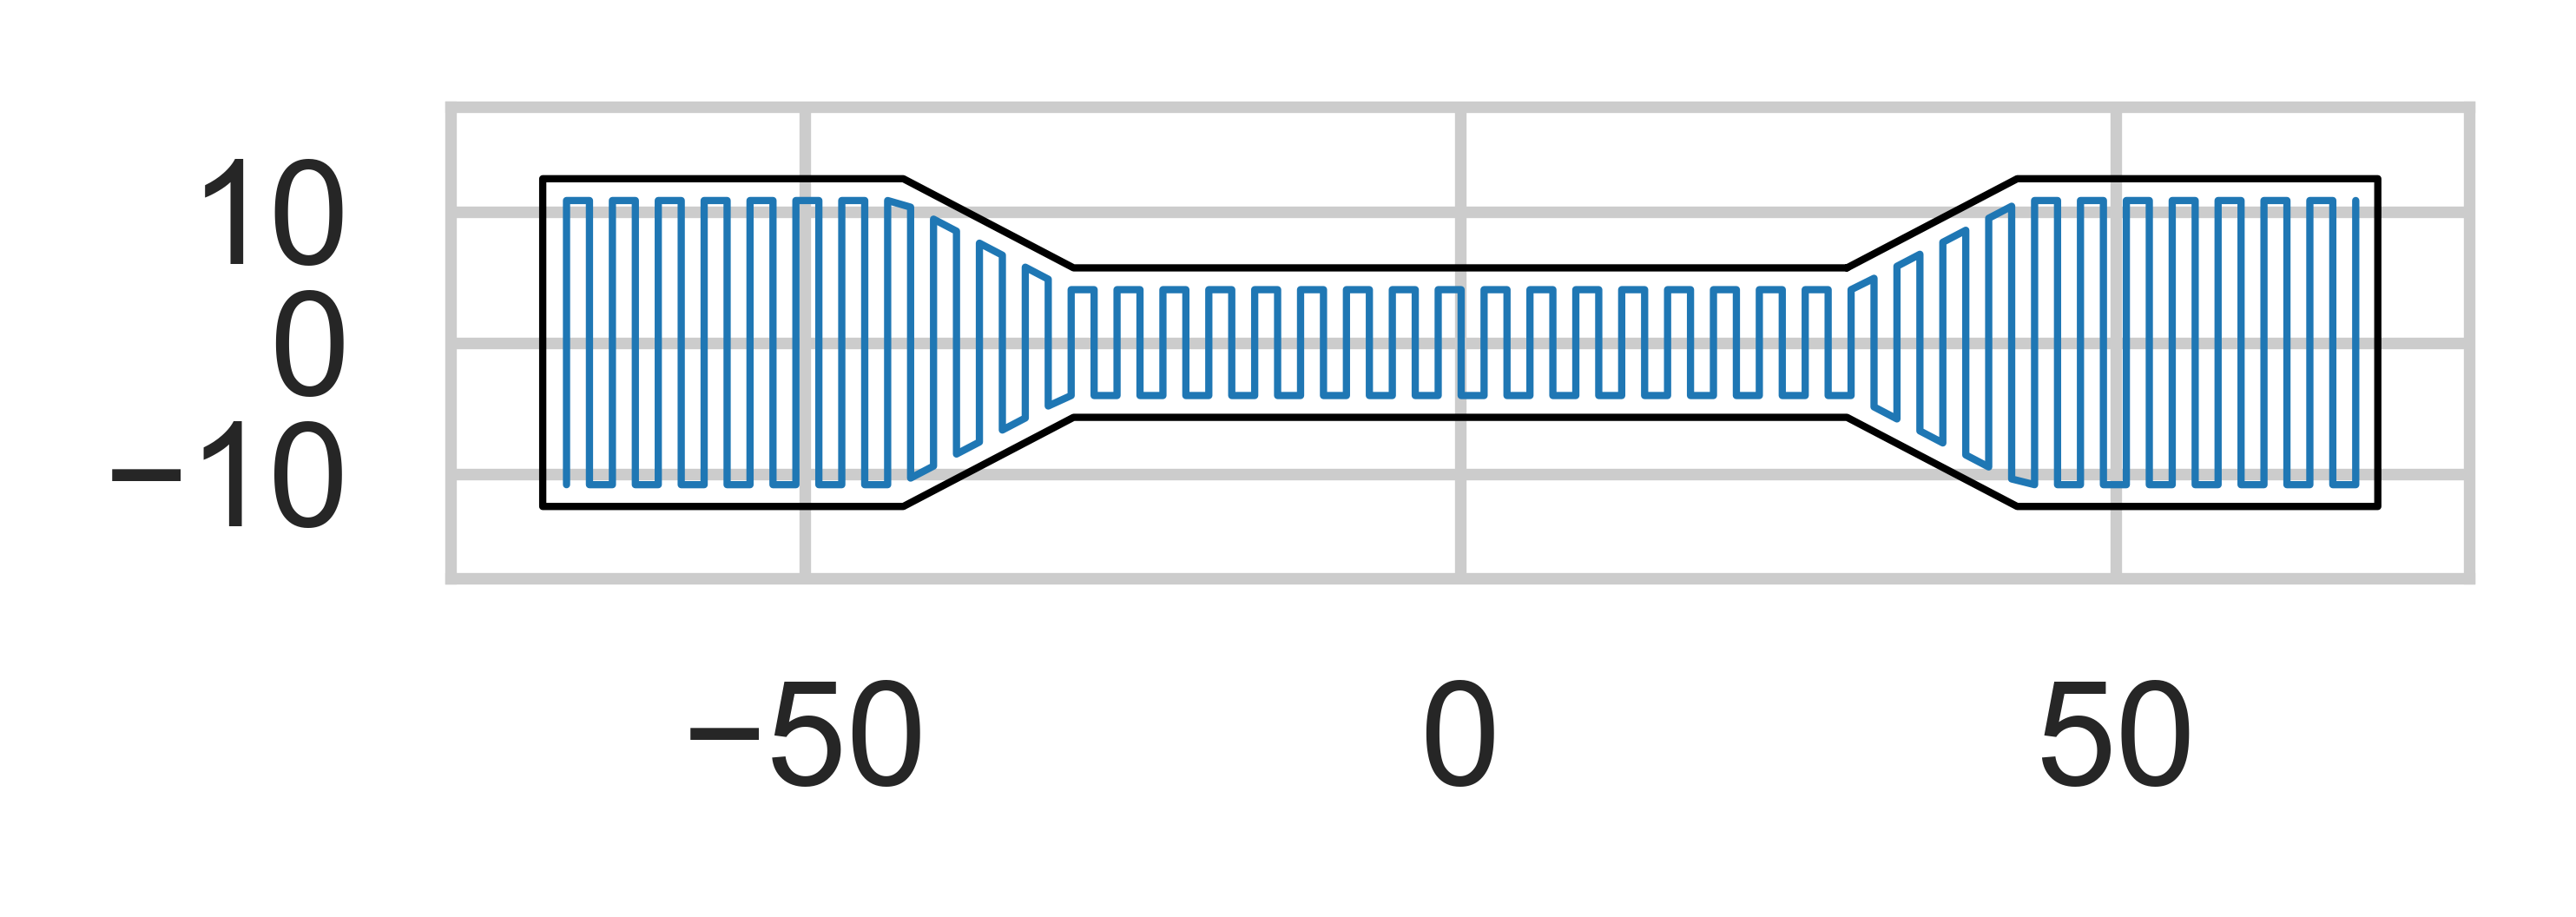

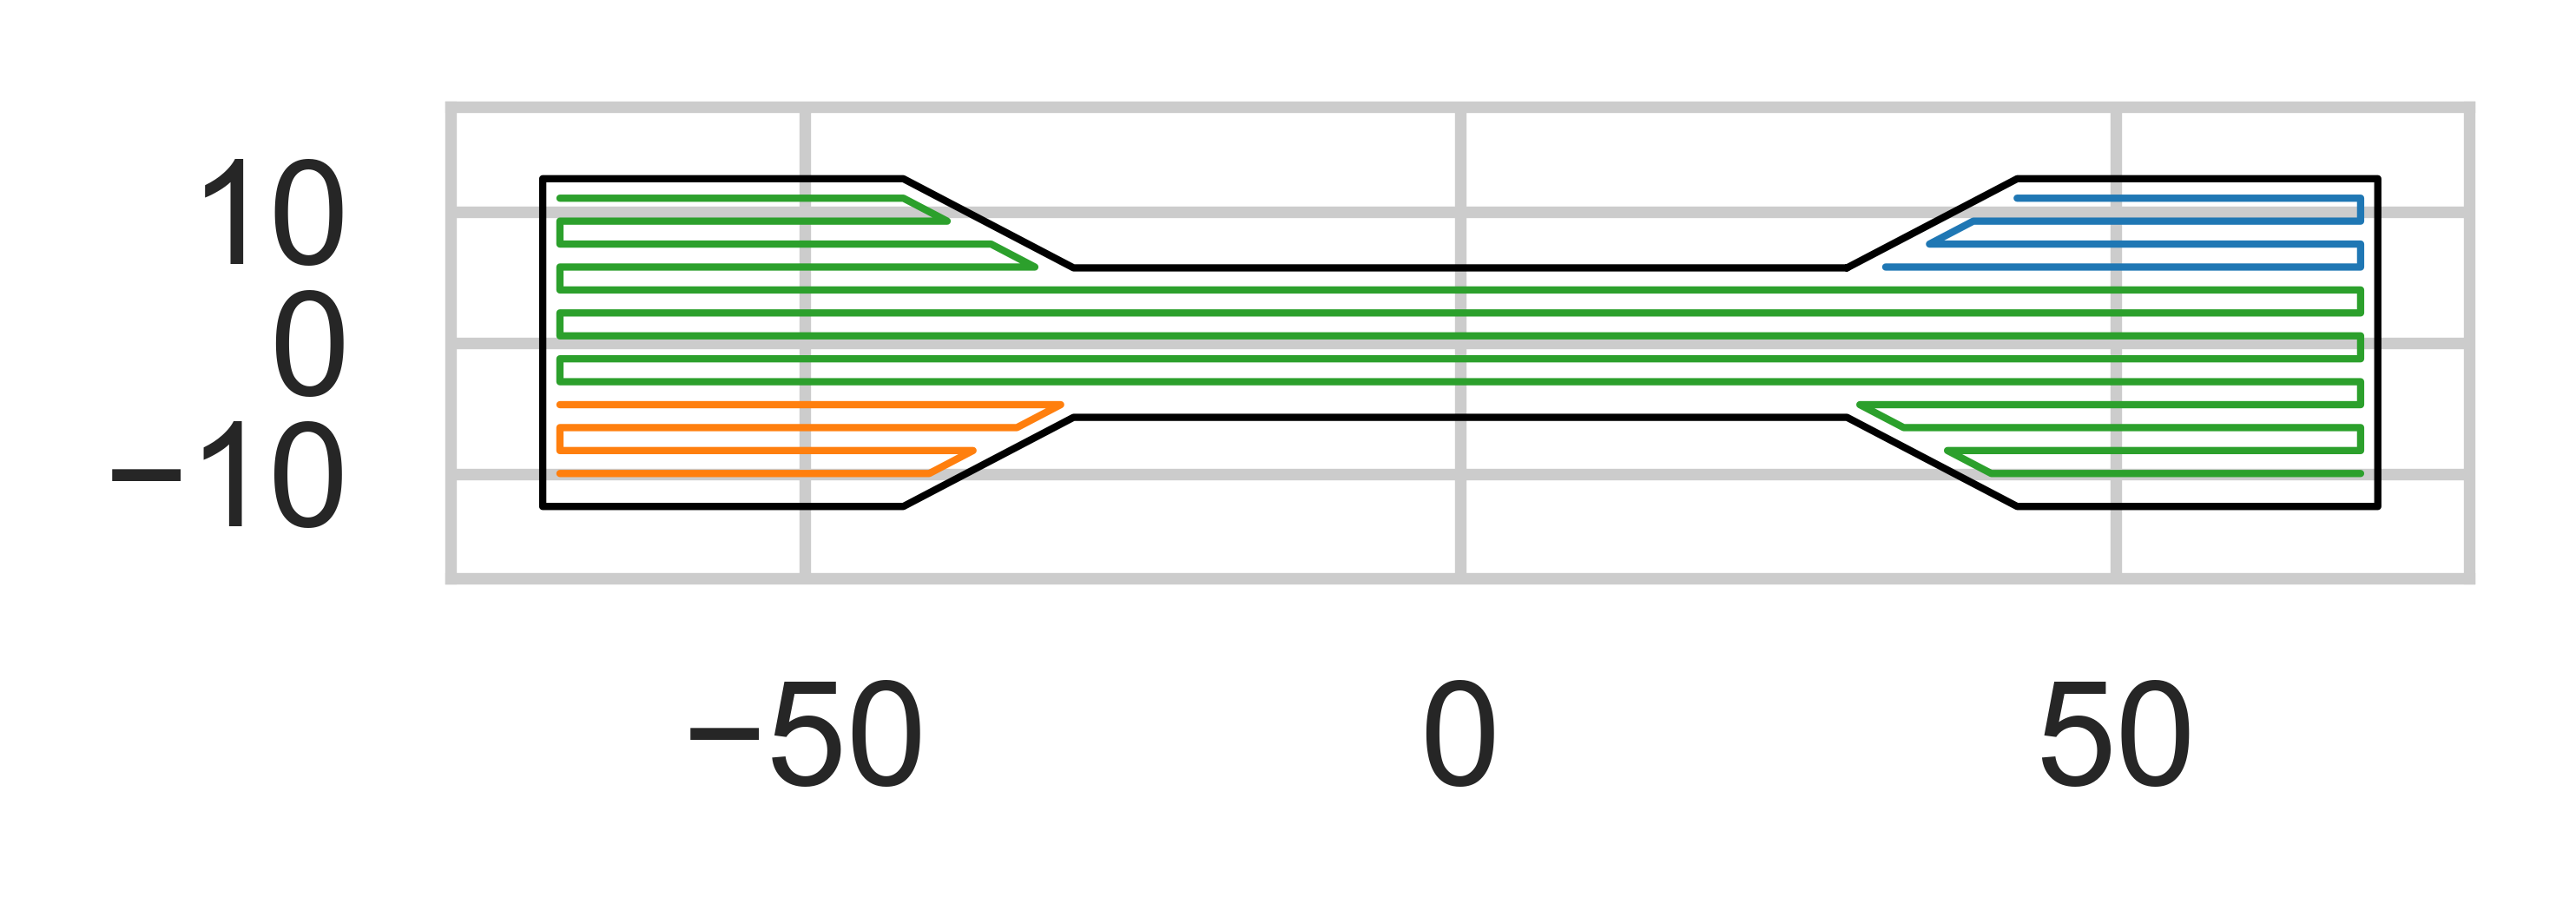

'Done'

In [7]:
###################################################################################################
print('feedrate_extrude={}'.format(gcode_para['feedrate_extrude']))

########################################################################
polygon_path(dog_bone,d,plotting=True,angle=np.pi/4*3,indication=False,figsize=(2.5,0.6),dpi=600)
polygon_path(dog_bone,d,plotting=True,angle=np.pi/4,indication=False,figsize=(2.5,0.6),dpi=600)
polygon_path(dog_bone,d,plotting=True,angle=0,indication=False,figsize=(2.5,0.6),dpi=600)
polygon_path(dog_bone,d,plotting=True,angle=np.pi/2,indication=False,figsize=(2.5,0.6),dpi=600)
'Done'

In [8]:
#script to
def criss_cross(dog_bone, d, num_layers, z, tool,plotting = False):
    # function to generate cris-cross pattern infill only,
    # not including the outline
    # num_layers<len(z)
    # return a path list consisting of
    # [[tool,path_opt[0]with_Z[0]]
    #  [tool,path_opt[1]with_Z[1]]
    #  [tool,path_opt[0]with_Z[2]]
    #  [tool,path_opt[1]with_Z[3]]
    #  .......] of num_layers elements
    lines_list_diag = []
    path_opt = [
        polygon_path(dog_bone, d, plotting= plotting, angle=np.pi / 4*3),
        polygon_path(dog_bone, d, plotting= plotting, angle=np.pi / 4)
    ]
    for i in range(num_layers):
        path = path_opt[i % 2]
        lines_list_diag.append(add_Z(path, z[i], tool))
    # insert point at begining
    firstPoint = lines_list_diag[0][1][0]
    lines_list_diag[0][1] =  np.vstack([[firstPoint[0],firstPoint[1],z[-1]],lines_list_diag[0][1]])
    # append point at last
    lastPoint = lines_list_diag[-1][-1][-1]
    lines_list_diag[-1][-1] = np.vstack([lines_list_diag[-1][-1],[lastPoint[0],lastPoint[1],z[-1]]])
        
    return (lines_list_diag)


# lines_list_diag = criss_cross(dog_bone, d, num_layers, z, SKIN,plotting = False)


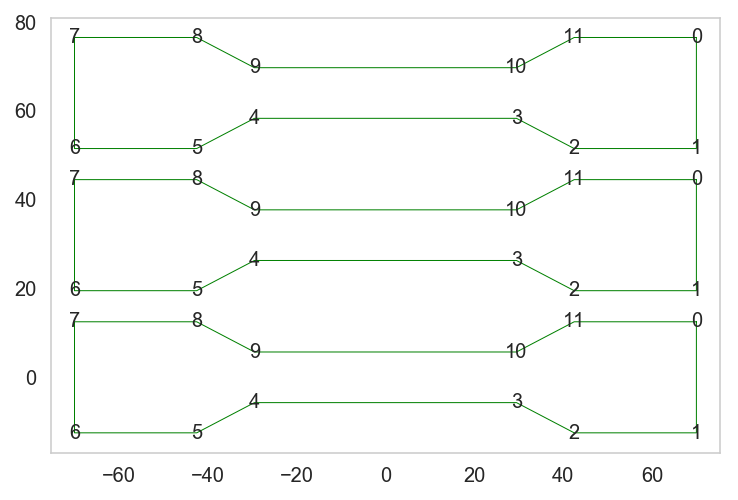

In [9]:
dx = 145
dy = 32

# for visualization
# dy = 80

x0 = 0
# y0 = -dy*2 # for 3
y0 = -dy # for 1
dog_bone_list = [StandardDogBone(x0+dx*i,y0+dy*j,'A',shift = -2) for i in range(1) for j in range(1,4)]
fig = plt.figure()
ax = fig.add_subplot(111)
for lines in dog_bone_list:
    ax.plot(lines[:,0],lines[:,1],color ='g',linewidth = 0.5)
    for k in range(len(lines)-1):
        ax.text(lines[k,0],lines[k,1], k, 
            fontsize=10,horizontalalignment='center',verticalalignment = 'center')
plt.axis('equal');plt.grid();plt.show();

In [10]:
# define infill_style option
VERTICLE = 0
HORIZONRAL = 1
CRISSCROSS = 2
######################################

infill_style = HORIZONRAL
# num_layers = 6
# for visualization
num_layers = 3

z_start = 0.5
z = height_vector(num_layers, d, z_start)
print("z vector = ")
print(z)
num_offset = 2
################################################
lines_list = []
wall_list = [np.vstack([offset_lines(lines, d * float(k), left=True)
                        for k in range(num_offset)]) for lines in dog_bone_list]


for z_i in z:
    for k in range(len(dog_bone_list)):# for 3 styles
#     for k in range(1):  # for 1 style
        lines_list.append(add_Z(wall_list[k], z_i, SKIN))

# print dog_bone with infill style specified by the infill_style_list
infill_style_list = [CRISSCROSS,VERTICLE,HORIZONRAL] # for 3 styles
# infill_style_list = [CRISSCROSS]  # for 1 style
for k, infill_style in enumerate(infill_style_list):
    dog_bone = dog_bone_list[k]
    if infill_style == CRISSCROSS:
        lines_list.extend(
            criss_cross(
                dog_bone,
                d,
                num_layers, z,
                tool=MUSCLE,
                plotting=False))

    else:
        infill = polygon_path(dog_bone, d, plotting=False,
                              angle=np.pi/2*infill_style)
        lines_list.append(add_Z(infill, z, MUSCLE))#, z_g0=z[-1]))

total_height>=3.339
z vector = 
[0.5        2.19193521 3.8386495 ]


In [11]:
for lines in lines_list:
    print(lines)
# print(lines_list)

[2, array([[ 70.        ,  12.5       ,   0.5       ],
       [ 70.        , -12.5       ,   0.5       ],
       [ 42.49      , -12.5       ,   0.5       ],
       [ 29.5       ,  -5.7       ,   0.5       ],
       [-29.5       ,  -5.7       ,   0.5       ],
       [-42.49      , -12.5       ,   0.5       ],
       [-70.        , -12.5       ,   0.5       ],
       [-70.        ,  12.5       ,   0.5       ],
       [-42.49      ,  12.5       ,   0.5       ],
       [-29.5       ,   5.7       ,   0.5       ],
       [ 29.5       ,   5.7       ,   0.5       ],
       [ 42.49      ,  12.5       ,   0.5       ],
       [ 70.        ,  12.5       ,   0.5       ],
       [ 71.75      ,  14.25      ,   0.5       ],
       [ 71.75      , -14.25      ,   0.5       ],
       [ 42.05965449, -14.25      ,   0.5       ],
       [ 29.06965449,  -7.45      ,   0.5       ],
       [-29.06965449,  -7.45      ,   0.5       ],
       [-42.05965449, -14.25      ,   0.5       ],
       [-71.75      , -14.2

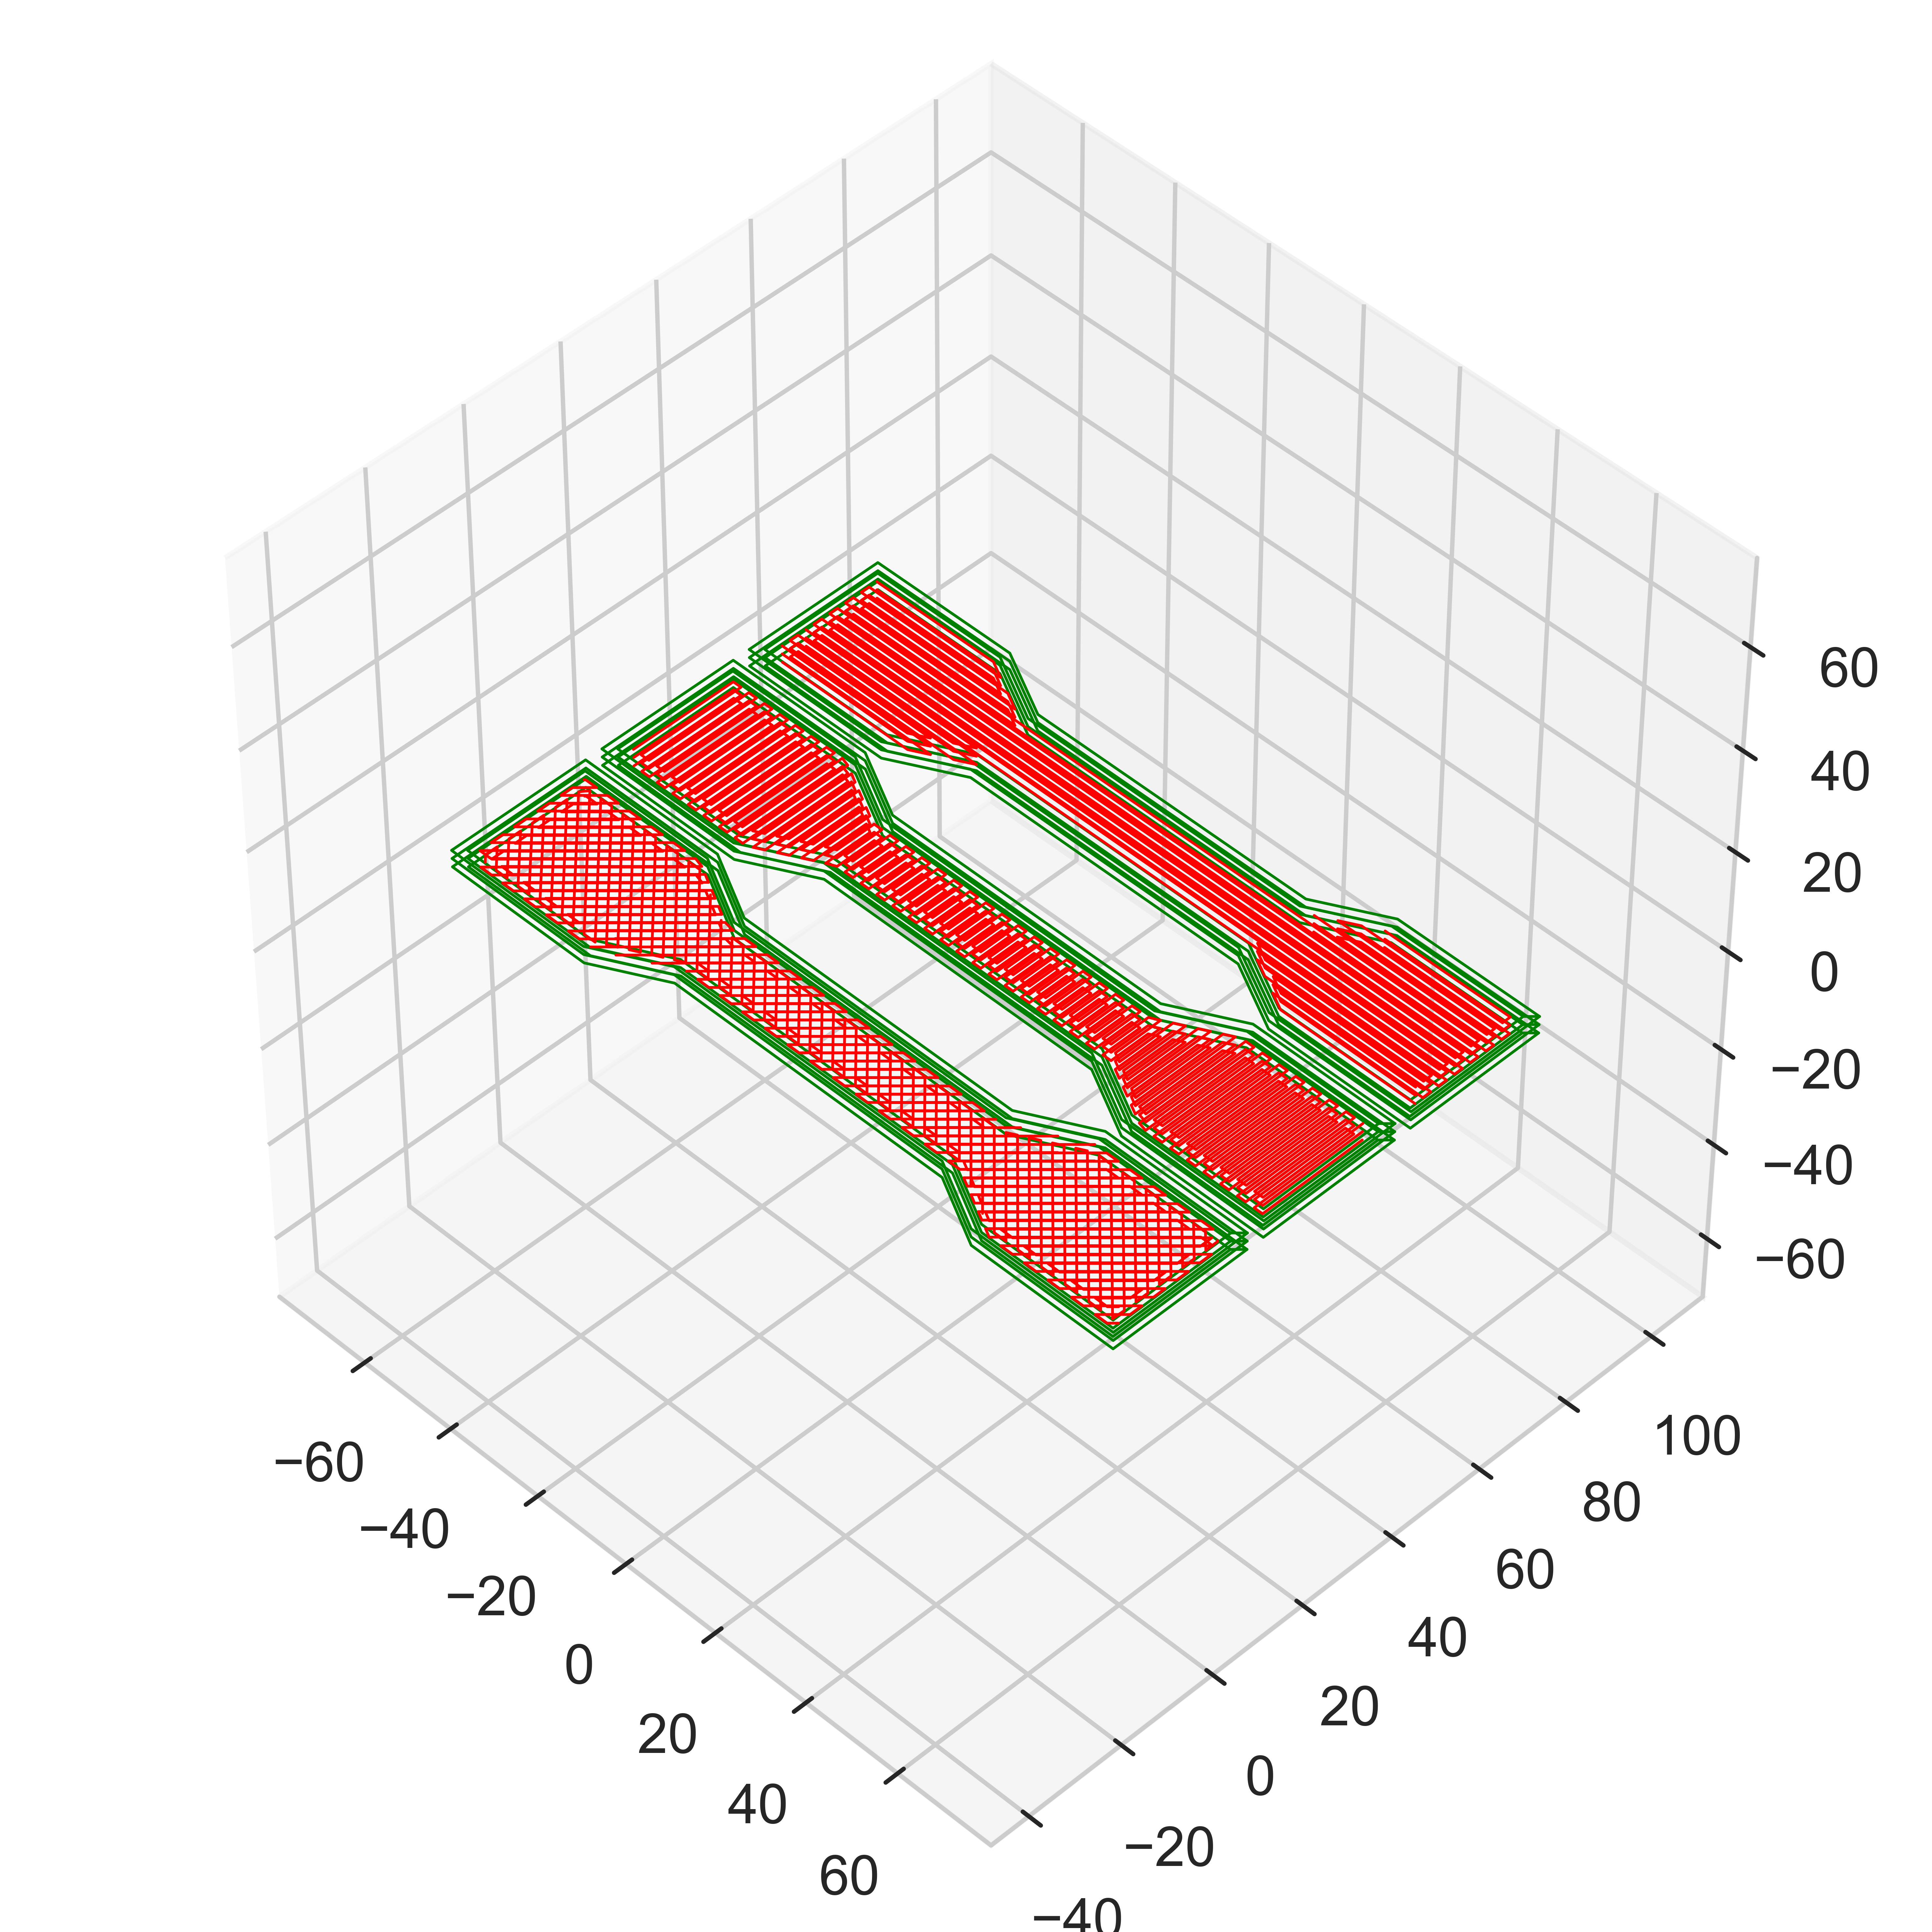

In [40]:
def plot_lines_list(lines_list, figsize=(6, 6), dpi=100, linewidth=0.5):
    """plot given a lines_list,which is in the format of 
    [[Material#,nx3_numpy_array,nx3_numpy_array,nx3_numpy_array...],
    [Material#,nx3_numpy_array,nx3_numpy_array,nx3_numpy_array...],
    [Material#,nx3_numpy_array,nx3_numpy_array,nx3_numpy_array...],
    .....
    ]
    @boxiXia
    """
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_subplot(111, projection='3d')
    for i, lines in enumerate(lines_list):
        for k in range(1, len(lines)):
            if lines[k][0, 2] != lines[k][1, 2]:
                #                 ax.plot(lines[k][:2, 0], lines[k][:2, 1], lines[k][:2, 2],
                #                     'b', linewidth=linewidth)
                ax.plot(lines[k][1:, 0], lines[k][1:, 1], lines[k][1:, 2],
                        c=COLORS[lines[0]], linewidth=linewidth)
            else:
                ax.plot(lines[k][:, 0], lines[k][:, 1], lines[k][:, 2],
                        c=COLORS[lines[0]], linewidth=linewidth)
#             try:
#                 ax.plot([lines[k][-1, 0], lines[k + 1][0, 0]],
#                         [lines[k][-1, 1], lines[k + 1][0, 1]],
#                         [lines[k][-1, 2], lines[k + 1][0, 2]], 'b', linewidth=linewidth)
#             except IndexError: # last point in the last array of a list
#                 pass
#                 try:
#                     ax.plot([lines_list[i][-1][-1, 0], lines_list[i+1][1][0, 0]],
#                             [lines_list[i][-1][-1, 1], lines_list[i+1][1][0, 1]],
#                             [lines_list[i][-1][-1, 2], lines_list[i+1][1][0, 2]],
#                             'b', linewidth=linewidth)
#                 except IndexError: # last point of all
#                     pass
    ax.axis('equal')


    # Create cubic bounding box to simulate equal aspect ratio
    xmax, ymax, zmax = np.vstack(
        [[line.max(axis=0) for line in lines[1:]] for lines in lines_list]).max(axis=0)
    xmin, ymin, zmin = np.vstack(
        [[line.min(axis=0) for line in lines[1:]] for lines in lines_list]).min(axis=0)

    max_range = np.array([xmax-xmin, ymax-ymin, zmax-zmin]).max()
    Xb = 0.5*max_range*np.mgrid[-1:2:2, -1:2:2, -
                                1:2:2][0].flatten() + 0.5*(xmax+xmin)
    Yb = 0.5*max_range*np.mgrid[-1:2:2, -1:2:2, -
                                1:2:2][1].flatten() + 0.5*(ymax+ymin)
    Zb = 0.5*max_range*np.mgrid[-1:2:2, -1:2:2, -
                                1:2:2][2].flatten() + 0.5*(zmax+zmin)
    # Comment or uncomment following both lines to test the fake bounding box:
    for xb, yb, zb in zip(Xb, Yb, Zb):
        ax.plot([xb], [yb], [zb], 'w')
    return ax


ax = plot_lines_list(lines_list, figsize=(5, 5),dpi=600)

# xmax, ymax, zmax = np.vstack(
#     [[line.max(axis=0) for line in lines[1:]] for lines in lines_list]).max(axis=0)
# xmin, ymin, zmin = np.vstack(
#     [[line.min(axis=0) for line in lines[1:]] for lines in lines_list]).min(axis=0)
# ax.set_xlim3d(xmin, xmax)
# ax.set_ylim3d(ymin, ymax)
# ax.set_zlim3d(zmin-3, zmax+3)
ax.view_init(elev=45., azim=-45)
plt.tight_layout()
plt.show()

In [33]:
g_code_strings = lines_list_to_gcode_strings(lines_list,gcode_para)  

# initialization
g_code_strings.insert(0,initial_gcode)

s = ''.join(g_code_strings)
if platform == 'win32':
    f = open('gcode/dog_bones.g','w')
else:
    f = open('gcode/dog_bones.g','w')
f.write(s)
f.close()
# print(s)

In [12]:
def sinebox(offset_x = -20,offset_y = 0):
    l_x = 46.5
    l_y = 1.6
    n_wave = 5
    n_points = 50
    x = np.linspace(0,l_x,n_points)
    y = np.sin(np.linspace(0,n_wave*np.pi,n_points))*l_y
    # plot
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     ax.plot(x,y)
#     plt.axis("equal")
#     plt.grid()
#     plt.show()
    h = 15
    line = np.empty((int(n_points*2+1),2))
    line[:,0]=np.hstack([x,np.flip(x,0),[0]])+offset_x
    line[:,1]=np.hstack([y+h/2,-np.flip(y,0)-h/2,[h/2]])+offset_y
    
    
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     ax.plot(line[:,0],line[:,1])
#     plt.axis("equal")
#     plt.grid()
#     plt.show()
    return line

In [13]:
h2=10
# script for mulitple sets of walls and muscle in one print TEST
# lines_list_vert = []
# lines_list_walls = []
lines_lists = []
x = -46.5/2
num_offset = 3
y = 0
dog_bone = sinebox(x,y)


# infills
path_list_infill_muscle = polygon_path(dog_bone,d,plotting=False,angle=0)
path_list_infill_muscle = np.vstack((path_list_infill_muscle[0][0],path_list_infill_muscle[0],path_list_infill_muscle[0][-1]))
path_list_infill_muscle_flip = np.flip(path_list_infill_muscle,0)

path_list_infill_skin = polygon_path(offset_lines(dog_bone,d*0.2,left = True),d,plotting=False,angle=0)
path_list_infill_skin = np.vstack((path_list_infill_skin[0][0],path_list_infill_skin[0],path_list_infill_skin[0][-1]))
path_list_infill_skin_flip=np.flip(path_list_infill_skin,0)
# walls
path_list_wall =np.vstack([offset_lines(dog_bone,d*float(k+0.1),left = True) for k in range(num_offset)])



lines_lists.append(add_Z(path_list_wall,z[0],SKIN)) # first layer of wall
lines_lists.append(add_Z(path_list_infill_muscle,z[0],SKIN,z_g0=z[-1])) # fist layer of infill 
lines_lists.append(add_Z(path_list_wall,z[1:],SKIN,z_g0=z[-1])) # the rest lyer of wall
for i,z_i in enumerate(z[1:-1]):
    if i%2==1:
        lines_lists.append(add_Z(path_list_infill_muscle,z_i,MUSCLE,z_g0=z[-1])) 
    else:
        lines_lists.append(add_Z(path_list_infill_muscle_flip,z_i,MUSCLE,z_g0=z[-1])) 
# lines_lists.append(add_Z(path_list_infill_muscle,z[1:-1],MUSCLE,z_g0=z[-1])) 
lines_lists.append(add_Z(path_list_infill_skin_flip,z[-1],SKIN,z_g0=z[-1]+0.5)) # top layer of infill-skin





#lines_list_walls = [lines_list_walls]
g_code_strings = lines_list_to_gcode_strings(lines_lists,gcode_para)
for gcode in g_code_strings:
    print(gcode)
# initialization
g_code_strings.insert(0,initial_gcode)
#print(g_code_strings)
s = ''.join(g_code_strings)


f = open('./gcode/dog_bones_muscle.g','w')
f.write(s)
f.close()

G0 X-23.349000 Y7.559508 Z0.500000 F6000
G1 X-22.345582 Y8.092603 Z0.500000 E0.000000:0.001087:0.001087:0.000000 F600
G1 X-21.390787 Y8.548182 Z0.500000 E0.000000:0.001012:0.001012:0.000000 F600
G1 X-20.431792 Y8.907230 Z0.500000 E0.000000:0.000980:0.000980:0.000000 F600
G1 X-19.468831 Y9.132088 Z0.500000 E0.000000:0.000946:0.000946:0.000000 F600
G1 X-18.503423 Y9.198528 Z0.500000 E0.000000:0.000926:0.000926:0.000000 F600
G1 X-17.538310 Y9.099239 Z0.500000 E0.000000:0.000928:0.000928:0.000000 F600
G1 X-16.576070 Y8.845118 Z0.500000 E0.000000:0.000952:0.000952:0.000000 F600
G1 X-15.617925 Y8.463392 Z0.500000 E0.000000:0.000987:0.000987:0.000000 F600
G1 X-14.663940 Y7.993920 Z0.500000 E0.000000:0.001017:0.001017:0.000000 F600
G1 X-13.713831 Y7.484956 Z0.500000 E0.000000:0.001031:0.001031:0.000000 F600
G1 X-12.767502 Y6.988432 Z0.500000 E0.000000:0.001023:0.001023:0.000000 F600
G1 X-11.825161 Y6.554749 Z0.500000 E0.000000:0.000993:0.000993:0.000000 F600
G1 X-10.887039 Y6.227474 Z0.500000 

In [14]:
def plot_lines_list(lines_list):
    """plot given a lines_list,which is in the format of 
    [[Material#,nx3_numpy_array,nx3_numpy_array,nx3_numpy_array...],
    [Material#,nx3_numpy_array,nx3_numpy_array,nx3_numpy_array...],
    [Material#,nx3_numpy_array,nx3_numpy_array,nx3_numpy_array...],
    .....
    ]
    @boxiXia
    """
    fig = plt.figure(figsize=(3,3),dpi=600)
    ax = fig.add_subplot(111, projection='3d')
    for lines in lines_list:
        for k in range(1,len(lines)):
            ax.plot(lines[k][:,0],lines[k][:,1],lines[k][:,2],c=COLORS[lines[0]],linewidth=.5)
            try:
                ax.plot([lines[k][-1,0],lines[k + 1][0,0]],[lines[k][-1,1],lines[k + 1][0,1]],[lines[k][-1,2],lines[k + 1][0,2]],'m',linewidth=.5)
            except IndexError:
                #last lines
                pass
    ax.axis('equal')
    return ax

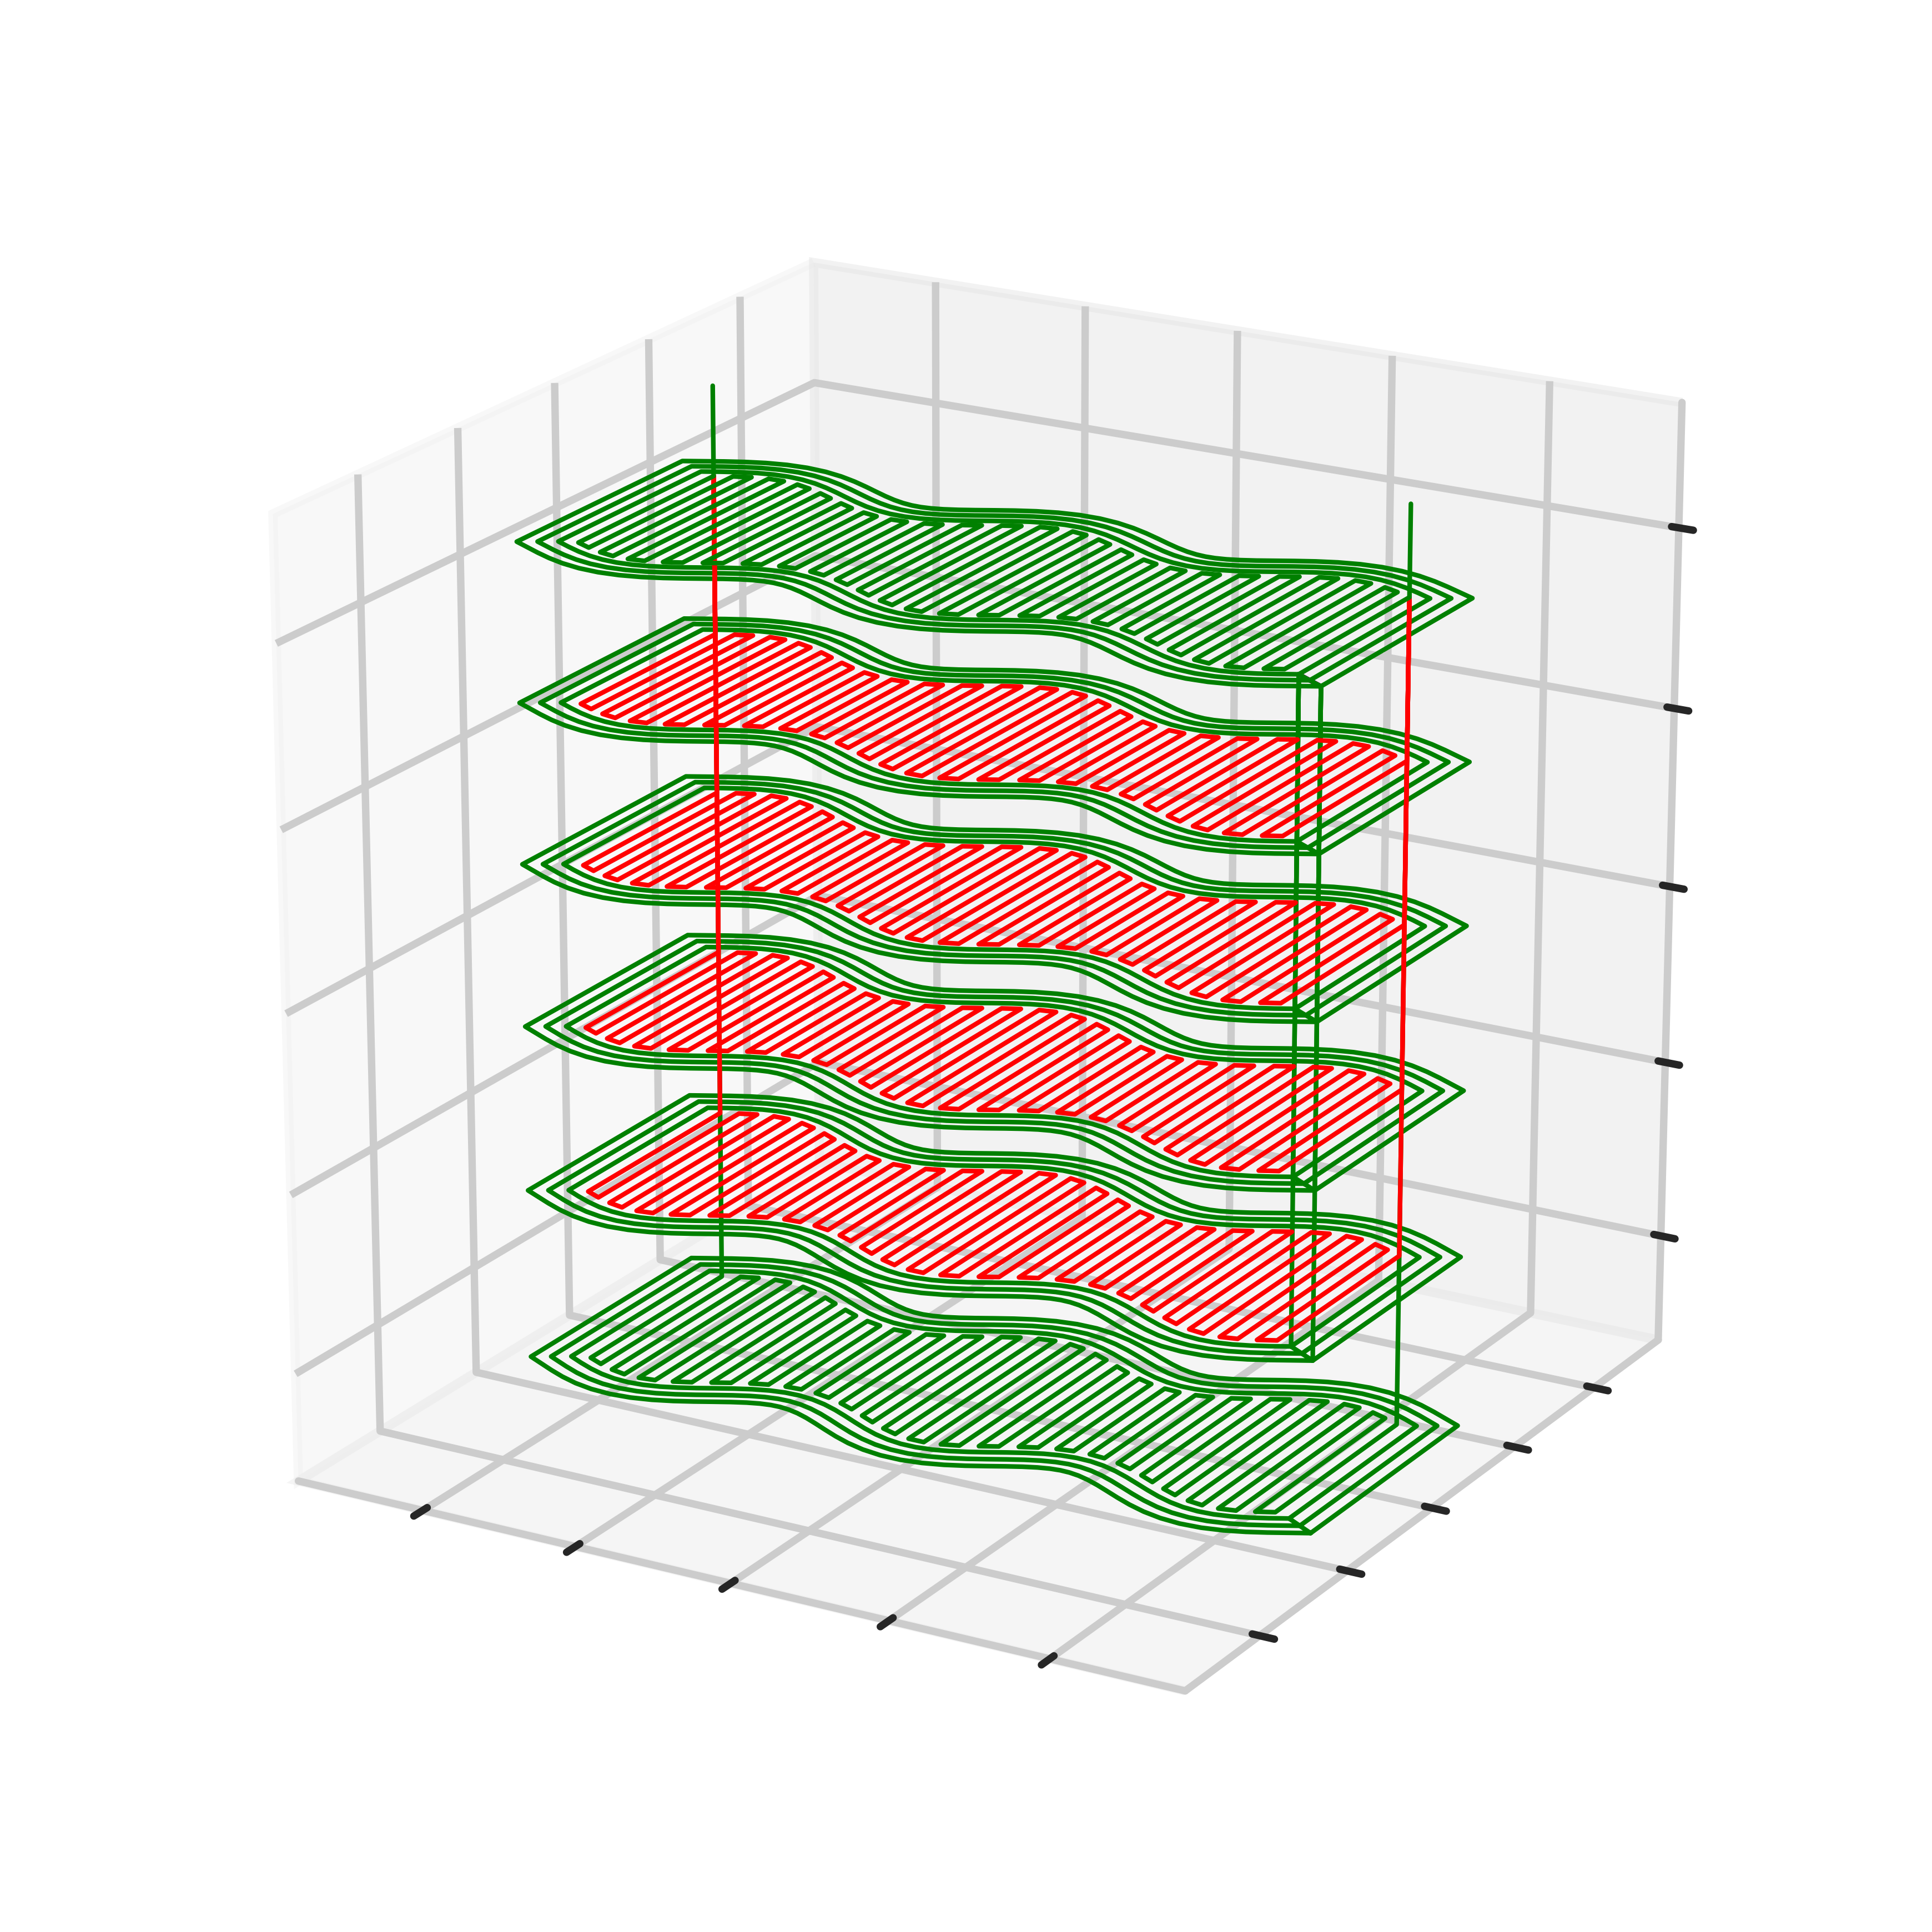

In [15]:
%matplotlib inline
ax = plot_lines_list(lines_lists)
# ax.plot(np.zeros(2),np.zeros(2),[0,20],alpha=0)
# ax.set_zlim3d(0,6)
plt.tight_layout()
ax.view_init(elev=20., azim=120)
# Turn off tick labels
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_zticklabels([])
plt.show()